In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch
import dnnlib
import argparse

from nerf.provider import NeRFDataset
from nerf.utils import *

In [3]:
from nerf.network_tcnn import NeRFNetwork

In [4]:
import numpy as np
from PIL import Image
from torchvision.utils import make_grid
@torch.no_grad()
def render_tensor(img: torch.Tensor, normalize: bool = False, nrow: int = 8) -> Image.Image:
    def process_dtype(img):
        if img.dtype == torch.uint8:
            img = img.to(torch.float32) / 255.
            if normalize:
                img = img * 2 - 1
        return img
    if type(img) == list:
        img = torch.cat([process_dtype(i) if len(i.shape) == 4 else process_dtype(i[None, ...]) for i in img], dim=0).expand(-1, 3, -1, -1)
    elif len(img.shape) == 3:
        img = process_dtype(img).expand(3, -1, -1)
    elif len(img.shape) == 4:
        img = process_dtype(img).expand(-1, 3, -1, -1)
    
    img = img.squeeze()
    
    if normalize:
        img = img / 2 + .5
    
    if len(img.shape) == 3:
        return Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 2:
        return Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 4:
        return Image.fromarray((make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

In [5]:
def convert_env_to_img(env):
    return torch.clamp(torch.pow(env, 0.45), 0, 1)

In [6]:
device = 'cuda'

In [7]:
model = NeRFNetwork(
    encoding="hashgrid",
    bound=2,
    cuda_ray=False,
    density_scale=1,
    min_near=0.2,
    density_thresh=10,
    bg_radius=1,
).to(device).requires_grad_(False)

In [8]:
train_loader = NeRFDataset(dnnlib.EasyDict(
    path='./data/nerf/fox', 
    preload=True, 
    scale=0.33, 
    offset=[0, 0, 0], 
    bound=2, 
    fp16=False, 
    num_rays=512, 
    rand_pose=-1, 
    error_map=False, 
    color_space='srgb', 
    patch_size=1
), device=device, type='val', downscale=8)

Loading val data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.16it/s]


In [9]:
train_loader.training = False

In [10]:
path = './fox_7/checkpoints/ngp.pth'

In [11]:
model.load_state_dict(torch.load(path, map_location=device)['model'])

<All keys matched successfully>

In [12]:
render_opt = dnnlib.EasyDict(
    max_ray_batch = 2048, 
    num_steps = 32, 
    indicator_steps = 64, 
    max_depths = 2
)

In [13]:
view = train_loader.collate([0])

In [18]:
_env_map = model.env_map

In [24]:
model.env_map = torch.nn.Parameter(torch.zeros_like(_env_map)).requires_grad_(False)

In [20]:
_env_map.shape

torch.Size([1, 3, 32, 64])

In [27]:
model.env_map = torch.nn.Parameter(torch.cat((
    _env_map[..., 10:], 
    _env_map[..., :10]
), dim=-1)).requires_grad_(False)

In [25]:
with torch.no_grad():
    outputs = model.render(view['rays_o'], view['rays_d'], **render_opt)

In [26]:
image = outputs['image'] / (outputs['image'] + 1)

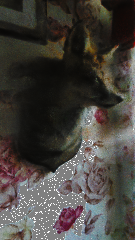

In [27]:
render_tensor([image.reshape_as(view['images']).permute(0, 3, 1, 2)])

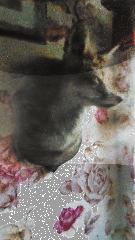

In [28]:
render_tensor([image.reshape_as(view['images']).permute(0, 3, 1, 2)])

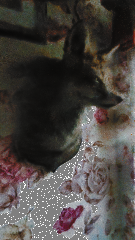

In [32]:
render_tensor([image.reshape_as(view['images']).permute(0, 3, 1, 2)])

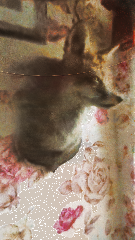

In [36]:
render_tensor([image.reshape_as(view['images']).permute(0, 3, 1, 2)])

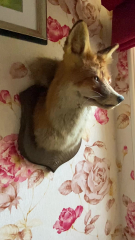

In [37]:
render_tensor([view['images'].permute(0, 3, 1, 2)])

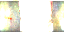

In [15]:
render_tensor(convert_env_to_img(torch.exp(model.env_map)))